In [1]:
import pickle
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import preprocessing
import pandas as pd
import os
import time, os
import pymysql
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import ta
import warnings

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 600)

warnings.filterwarnings(action='ignore')



%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15,7)

Populating the interactive namespace from numpy and matplotlib


 # 평가지표 함수

In [8]:
def plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob):
    from sklearn.metrics import roc_curve, roc_auc_score, f1_score, f1_score, accuracy_score, recall_score, precision_score
    
    fpr, tpr, thresholds = roc_curve(testY, test_prob) # output 3개가 나오는데, 각 threshhold 마다의 fpr, tpr값 인듯
    
    train_f1 = f1_score(trainY, train_pred)
    test_f1 = f1_score(testY, test_pred)
    
    train_recall = recall_score(trainY, train_pred)
    test_recall = recall_score(testY, test_pred)
    
    train_pre = precision_score(trainY, train_pred)
    test_pre = precision_score(testY, test_pred)  
    
    train_acc = accuracy_score(trainY, train_pred)
    test_acc = accuracy_score(testY, test_pred)
    
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(testY, test_prob),3)),fontsize=25)
    plt.legend()
    plt.show()
    print('train_f1 score: ',train_f1)
    print('test_f1 score: ',test_f1,'\n')
    
    print('train_recall score: ',train_recall)
    print('test_recall score: ',test_recall,'\n')

    print('train_pre score: ',train_pre)
    print('test_pre score: ',test_pre,'\n')
    
    print('train acc score: ',train_acc)
    print('test acc score: ',test_acc, '\n')

#  스케일링 방법: 전날 종가로 나누기

- 가격관련 컬럼들만 전날 종가로 나누어서 스케일링

## train 데이터 생성 함수

In [2]:
def make_data_train(trading, days, label): 
    # traiding: 거래대금 임계값, days: 일 수, label: next_chang 임계 값
    
    # 코드 리스트 
    IF=open("code_list.txt", 'r')
    lst_code = IF.readlines()
    
    # trainX, trainY
    lst_trainX = []
    lst_trainY = []
    
    # database
    db_dsml = pymysql.connect(
        host = 'localhost', 
        port = 3306, 
        user = 'stock_user', 
        passwd = 'bigdata', 
        db = 'refined_stock', 
        charset = 'utf8'
    )
    cursor = db_dsml.cursor()
    
    
    col_scaling = ['Open', 'High', 'Low', 'Close', 'Trading', 'MA5', 'MA20', 'MA60', 'MA120', 
               'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
               'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD']   

    col_no_scaling = ['Change', 'Volume', 'MFI', 'ADI', 'OBV','CMF', 'FI', 'EOM, EMV', 
                      'VPT', 'NVI', 'ATR', 'UI', 'ADX', '-VI', '+VI', 'TRIX', 'MI', 
                      'CCI', 'DPO', 'KST', 'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
                       'WR', 'AO', 'ROC', 'PPO', 'PVO']
       
    for line in tqdm(lst_code): 
        code = line.strip()
        sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date BETWEEN '2017-12-28' AND '2020-12-31'
                    '''.format(code)

        stock = pd.read_sql(sql=sql_query, con=db_dsml)
        stock['BeforeClose'] = stock['Close'].shift(1) # 전날 종가 컬럼 추가
        stock.dropna(inplace=True) # nan 제거 
        lst_stock = stock.values.tolist()
        
        # scaling 필요 컬럼: 전날 종가로 나누어 스케일링
        stock['Trading'] = stock['Close'] * stock['Volume'] # 거래대금 컬럼 추가 
        scale_stock = stock[col_scaling].apply(lambda x: x/stock['BeforeClose'])
        lst_scale = scale_stock.values.tolist()

        # sclaling 필요x 컬럼 
        no_scale_stock = stock[col_no_scaling]
        lst_no_scale = no_scale_stock.values.tolist()        
        
        for i, row in enumerate(lst_stock): 
            date, close, volume, ma20 = row[0].strftime('%Y%m%d'), row[4], row[5], row[9]
            # 거래대금, 이동평균선 범위 조건
            if (close * volume >= trading) :
                if i < (days-1):   # 예외 처리 
                    continue                               

                result=[]
                for row2, row3 in zip(lst_scale[i-(days-1):i+1], lst_no_scale[i-(days-1):i+1]):  # scaling, no scaling 
                    result += row2+row3 # scaling + no scaling                 
                y = int(row[7]>=label) # next change 사용   
                
                lst_trainX.append(result)
                lst_trainY.append(y)
    
    return np.array(lst_trainX), np.array(lst_trainY)

## test 데이터 생성 함수

In [7]:
def make_data_test(trading, days, label): 
    # traiding: 거래대금 임계값, days: 일 수, label: next_chang 임계 값
    
    # 코드 리스트 
    IF=open("code_list.txt", 'r')
    lst_code = IF.readlines()
    
    # testX, testY
    lst_testX = []
    lst_testY = []
    
    # database
    db_dsml = pymysql.connect(
        host = 'localhost', 
        port = 3306, 
        user = 'stock_user', 
        passwd = 'bigdata', 
        db = 'refined_stock', 
        charset = 'utf8'
    )
    cursor = db_dsml.cursor()
    
    
    col_scaling = ['Open', 'High', 'Low', 'Close', 'Trading', 'MA5', 'MA20', 'MA60', 'MA120', 
               'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
               'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD']   

    col_no_scaling = ['Change', 'Volume', 'MFI', 'ADI', 'OBV','CMF', 'FI', 'EOM, EMV', 
                      'VPT', 'NVI', 'ATR', 'UI', 'ADX', '-VI', '+VI', 'TRIX', 'MI', 
                      'CCI', 'DPO', 'KST', 'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
                       'WR', 'AO', 'ROC', 'PPO', 'PVO']
       
    for line in tqdm(lst_code): 
        code = line.strip()
        sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date BETWEEN '2020-12-30' AND '2021-06-31'
                    '''.format(code)

        stock = pd.read_sql(sql=sql_query, con=db_dsml)
        stock['BeforeClose'] = stock['Close'].shift(1) # 전날 종가 컬럼 추가
        stock.dropna(inplace=True) # nan 제거 
        lst_stock = stock.values.tolist()
        
        # scaling 필요 컬럼: 전날 종가로 나누어 스케일링
        stock['Trading'] = stock['Close'] * stock['Volume'] # 거래대금 컬럼 추가 
        scale_stock = stock[col_scaling].apply(lambda x: x/stock['BeforeClose'])
        lst_scale = scale_stock.values.tolist()

        # sclaling 필요x 컬럼 
        no_scale_stock = stock[col_no_scaling]
        lst_no_scale = no_scale_stock.values.tolist()        
        
        for i, row in enumerate(lst_stock): 
            date, close, volume, ma20 = row[0].strftime('%Y%m%d'), row[4], row[5], row[9]
            # 거래대금, 이동평균선 범위 조건
            if (close * volume >= trading) :
                if i < (days-1):   # 예외 처리 
                    continue                               

                result=[]
                for row2, row3 in zip(lst_scale[i-(days-1):i+1], lst_no_scale[i-(days-1):i+1]):  # scaling, no scaling 
                    result += row2+row3 # scaling + no scaling                 
                y = int(row[7]>=label) # next change 사용   
                
                lst_testX.append(result)
                lst_testY.append(y)
    
    return np.array(lst_testX), np.array(lst_testY)

## 데이터 생성

In [9]:
trainX, trainY = make_data_train(trading=1000000000, days=10, label=0.02)
testX, testY = make_data_test(trading=1000000000, days=10, label=0.02)

100%|███████████████████████████████████████| 1561/1561 [00:35<00:00, 43.43it/s]


## 평가지표 확인

In [11]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_jobs=30)

xgb.fit(trainX, trainY)

train_prob = xgb.predict_proba(trainX)[:, 1]
train_pred = xgb.predict(trainX)
test_prob = xgb.predict_proba(testX)[:, 1]
test_pred = xgb.predict(testX)

[19:08:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


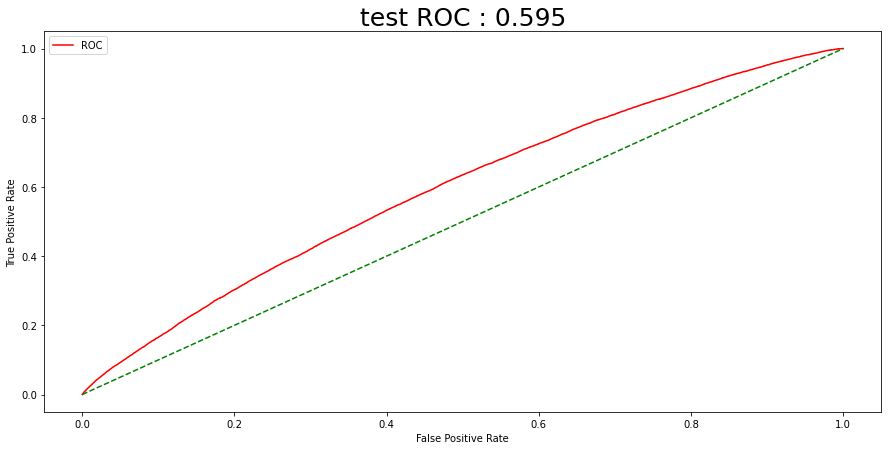

train_f1 score:  0.19925841274017317
test_f1 score:  0.026037828543355443 

train_recall score:  0.11236184259327943
test_recall score:  0.01347914547304171 

train_pre score:  0.8791990132772256
test_pre score:  0.381294964028777 

train acc score:  0.810181720379812
test acc score:  0.8025218105902764 



In [12]:
plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob)

# 스케일링 방법: min-max

- 가격관련 컬럼들만 min max 스케일링

## train 데이터 생성 함수

In [20]:
def make_data_train(trading, days, label): 
    # traiding: 거래대금 임계값, days: 일 수, label: next_chang 임계 값
    
    # 코드 리스트 
    IF=open("code_list.txt", 'r')
    lst_code = IF.readlines()
    
    # trainX, trainY
    lst_trainX = []
    lst_trainY = []
    
    # database
    db_dsml = pymysql.connect(
        host = 'localhost', 
        port = 3306, 
        user = 'stock_user', 
        passwd = 'bigdata', 
        db = 'refined_stock', 
        charset = 'utf8'
    )
    cursor = db_dsml.cursor()
    
    
    col_scaling = ['Open', 'High', 'Low', 'Close', 'Trading', 'MA5', 'MA20', 'MA60', 'MA120', 
               'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
               'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD']   

    col_no_scaling = ['Change', 'Volume', 'MFI', 'ADI', 'OBV','CMF', 'FI', 'EOM, EMV', 
                      'VPT', 'NVI', 'ATR', 'UI', 'ADX', '-VI', '+VI', 'TRIX', 'MI', 
                      'CCI', 'DPO', 'KST', 'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
                       'WR', 'AO', 'ROC', 'PPO', 'PVO']
       
    for line in tqdm(lst_code): 
        code = line.strip()
        sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date BETWEEN '2017-12-28' AND '2020-12-31'
                    '''.format(code)

        stock = pd.read_sql(sql=sql_query, con=db_dsml)
        stock.dropna(inplace=True) # nan 제거 
        lst_stock = stock.values.tolist()
        
        # scaling 필요 컬럼: min-max 스케일링
        stock['Trading'] = stock['Close'] * stock['Volume'] # 거래대금 컬럼 추가
        scaler = MinMaxScaler()
        scale_stock = scaler.fit_transform(stock[col_scaling])
        scale_stock = pd.DataFrame(scale_stock, columns=col_scaling)
        lst_scale = scale_stock.values.tolist()

        # sclaling 필요x 컬럼 
        no_scale_stock = stock[col_no_scaling]
        lst_no_scale = no_scale_stock.values.tolist()        
        
        for i, row in enumerate(lst_stock): 
            date, close, volume, ma20 = row[0].strftime('%Y%m%d'), row[4], row[5], row[9]
            # 거래대금, 이동평균선 범위 조건
            if (close * volume >= trading) :
                if i < (days-1):   # 예외 처리 
                    continue                               

                result=[]
                for row2, row3 in zip(lst_scale[i-(days-1):i+1], lst_no_scale[i-(days-1):i+1]):  # scaling, no scaling 
                    result += row2+row3 # scaling + no scaling                 
                y = int(row[7]>=label) # next change 사용   
                
                lst_trainX.append(result)
                lst_trainY.append(y)
    
    return np.array(lst_trainX), np.array(lst_trainY)

## test 데이터 생성 함수

In [22]:
def make_data_test(trading, days, label): 
    # traiding: 거래대금 임계값, days: 일 수, label: next_chang 임계 값
    
    # 코드 리스트 
    IF=open("code_list.txt", 'r')
    lst_code = IF.readlines()
    
    # testX, testY
    lst_testX = []
    lst_testY = []
    
    # database
    db_dsml = pymysql.connect(
        host = 'localhost', 
        port = 3306, 
        user = 'stock_user', 
        passwd = 'bigdata', 
        db = 'refined_stock', 
        charset = 'utf8'
    )
    cursor = db_dsml.cursor()
    
    
    col_scaling = ['Open', 'High', 'Low', 'Close', 'Trading', 'MA5', 'MA20', 'MA60', 'MA120', 
               'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
               'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD']   

    col_no_scaling = ['Change', 'Volume', 'MFI', 'ADI', 'OBV','CMF', 'FI', 'EOM, EMV', 
                      'VPT', 'NVI', 'ATR', 'UI', 'ADX', '-VI', '+VI', 'TRIX', 'MI', 
                      'CCI', 'DPO', 'KST', 'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
                       'WR', 'AO', 'ROC', 'PPO', 'PVO']
       
    for line in tqdm(lst_code): 
        code = line.strip()
        sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date BETWEEN '2020-12-30' AND '2021-06-31'
                    '''.format(code)

        stock = pd.read_sql(sql=sql_query, con=db_dsml)
        stock.dropna(inplace=True) # nan 제거 
        lst_stock = stock.values.tolist()
        
        # scaling 필요 컬럼: min-max 스케일링
        stock['Trading'] = stock['Close'] * stock['Volume'] # 거래대금 컬럼 추가
        scaler = MinMaxScaler()
        scale_stock = scaler.fit_transform(stock[col_scaling])
        scale_stock = pd.DataFrame(scale_stock, columns=col_scaling)
        lst_scale = scale_stock.values.tolist()

        # sclaling 필요x 컬럼 
        no_scale_stock = stock[col_no_scaling]
        lst_no_scale = no_scale_stock.values.tolist()        
        
        for i, row in enumerate(lst_stock): 
            date, close, volume, ma20 = row[0].strftime('%Y%m%d'), row[4], row[5], row[9]
            # 거래대금, 이동평균선 범위 조건
            if (close * volume >= trading) :
                if i < (days-1):   # 예외 처리 
                    continue                               

                result=[]
                for row2, row3 in zip(lst_scale[i-(days-1):i+1], lst_no_scale[i-(days-1):i+1]):  # scaling, no scaling 
                    result += row2+row3 # scaling + no scaling                 
                y = int(row[7]>=label) # next change 사용   
                
                lst_testX.append(result)
                lst_testY.append(y)
    
    return np.array(lst_testX), np.array(lst_testY)

## 데이터 생성

In [23]:
trainX, trainY = make_data_train(trading=1000000000, days=10, label=0.02)
testX, testY = make_data_test(trading=1000000000, days=10, label=0.02)

100%|███████████████████████████████████████| 1561/1561 [00:34<00:00, 45.82it/s]


## 평가지표 확인

In [28]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_jobs=30)

xgb.fit(trainX, trainY)

train_prob = xgb.predict_proba(trainX)[:, 1]
train_pred = xgb.predict(trainX)
test_prob = xgb.predict_proba(testX)[:, 1]
test_pred = xgb.predict(testX)

[19:55:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


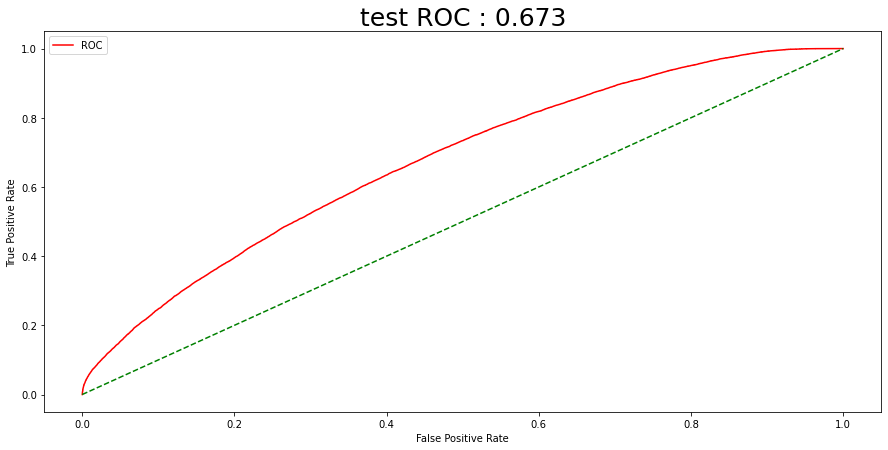

train_f1 score:  0.18456367504739513
test_f1 score:  0.13396952211865662 

train_recall score:  0.10315756353069648
test_recall score:  0.07634263552820167 

train_pre score:  0.8753042795445622
test_pre score:  0.5464695232347616 

train acc score:  0.8083084066861149
test acc score:  0.8073254828383571 



In [29]:
plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob)

# 결과

roc의 결과는 min-max scaling 방법이 더 좋지만 다른 평가지표의 결과는 전날 종가로 나누는 방법이 더 좋음. 전체적으로 종목코드의 각 날짜마다 전날 종가로 나누는 방법이 min-max 방법보다 오류가 적고 성능도 안정적인 방법이라고 판단. 스케일링 방법은 전날 종가로 나누는 방법으로 결정